Sentiment Analysis using LSTM Cells

In [94]:
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
import string

In [44]:
# cell phone accessories reviews dataset
data = pd.read_json('Cell_Phones_and_Accessories_5.json', lines=True)
data.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A30TL5EWN6DFXT,120401325X,christina,"[0, 0]",They look good and stick good! I just don't li...,4,Looks Good,1400630400,"05 21, 2014"
1,ASY55RVNIL0UD,120401325X,emily l.,"[0, 0]",These stickers work like the review says they ...,5,Really great product.,1389657600,"01 14, 2014"
2,A2TMXE2AFO7ONB,120401325X,Erica,"[0, 0]",These are awesome and make my phone look so st...,5,LOVE LOVE LOVE,1403740800,"06 26, 2014"
3,AWJ0WZQYMYFQ4,120401325X,JM,"[4, 4]",Item arrived in great time and was in perfect ...,4,Cute!,1382313600,"10 21, 2013"
4,ATX7CZYFXI1KW,120401325X,patrice m rogoza,"[2, 3]","awesome! stays on, and looks great. can be use...",5,leopard home button sticker for iphone 4s,1359849600,"02 3, 2013"


In [131]:
# Reviews + rating extraction
reviews_overall = data[['reviewText', 'overall']]
reviews_overall = reviews_overall[
    (reviews_overall['reviewText'].notna()) &
    (reviews_overall['reviewText'].str.strip() != '') &
    (reviews_overall['overall'].notna()) &
    (reviews_overall['reviewText'].str.len() < 200)
]
print(reviews_overall.shape)
reviews = reviews_overall['reviewText'].astype(str).values
reviews = [rev.lower() for rev in reviews if rev.strip() != '' and rev.lower() != 'nan']

# dropping stop words, punctuation and numbers
en_stop_words = set(stopwords.words('english'))
def remove_stopwords_punct_digits(rev):
    tokens = rev.split()
    filtered_tokens = [word.translate(str.maketrans('', '', string.punctuation)) for word in tokens]
    filtered_tokens = [word for word in filtered_tokens if word.isalpha() and word not in en_stop_words]
    return ' '.join(filtered_tokens)

reviews = [remove_stopwords_punct_digits(rev) for rev in reviews]
reviews[:5]

(79639, 2)


['look good stick good dont like rounded shape always bumping siri kept popping irritating wont buy product like',
 'stickers work like review says stick great stay phone super stylish share sister',
 'awesome make phone look stylish used one far almost year believe one year great quality',
 'awesome stays looks great used multiple apple products especially nails helps elevated key',
 'make using home button easy daughter like would purchase well worth price']

In [132]:
# Sentiment labeling based on ratings
def sentiment_label(rating):
    if rating <= 2:
        return 0  # Negative
    elif rating == 3:
        return 1  # Neutral
    else:
        return 2  # Positive

# selecting overall rows which are in reviews after dropping nulls
review_labels = reviews_overall['overall'].apply(sentiment_label).values
review_labels[:5]
review_labels.shape

(79639,)

In [133]:
# Tokenization and padding
tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(reviews)
vocab_size = len(tokenizer.word_index) + 1
sequences = tokenizer.texts_to_sequences(reviews)
max_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')
max_length, vocab_size

(33, 29880)

In [134]:
# Display sample tokenized sequences and labels
for i in range(5):
    print(f"Original: {reviews[i]}")
    print(f"Tokenized: {padded_sequences[i]}")
    print(f"Sentiment Label: {review_labels[i]}")
    print()

Original: look good stick good dont like rounded shape always bumping siri kept popping irritating wont buy product like
Tokenized: [  55    5  430    5   33    6 3159  657  141 5031 2838  485 2213 3605
  188   25   11    6    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0]
Sentiment Label: 2

Original: stickers work like review says stick great stay phone super stylish share sister
Tokenized: [1058   29    6  516  298  430    4  285    2  161  360 1204  493    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0]
Sentiment Label: 2

Original: awesome make phone look stylish used one far almost year believe one year great quality
Tokenized: [114 124   2  55 360  60   8  85 286 292 662   8 292   4  30   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Sentiment Label: 2

Original: awesome stays looks great used multiple apple products especially nails helps elevated key
Tokenized: [ 114  404  

In [156]:
# Train-test split
x_train, x_test, y_train, y_test = train_test_split(padded_sequences, review_labels, test_size=0.2, random_state=42)

In [157]:
# Check train data
x_train[:5], y_train[:5]

(array([[   47,   129,     3,   161,   126,    48,   192,  2995,    15,
           169,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0],
        [   16,     6,  1396,  2637,   411,   209,   247,  2637,   480,
            13,   519,   345,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0],
        [    7,   156,   243,   901,  2406,     3,    14,    50,    17,
         27466,  2105,    13,   136,    22,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0],
        [   10,     5,    67,   520,     2,     9,   197,   544,   129,
            17,    21,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,  

In [162]:
# LSTM Model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=64, input_length=max_length))
model.add(LSTM(units=64))
model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

d:\Softwares\DL\conda\envs\dl_venv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_25 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_25 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [166]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
model.fit(x_train, y_train, epochs=30, batch_size=128, validation_data=(x_test, y_test), callbacks=[early_stopping])

Epoch 1/30
498/498 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - accuracy: 0.8768 - loss: 0.3213 - val_accuracy: 0.8400 - val_loss: 0.4522
Epoch 2/30
498/498 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step - accuracy: 0.8880 - loss: 0.2936 - val_accuracy: 0.8363 - val_loss: 0.4730
Epoch 3/30
498/498 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - accuracy: 0.9003 - loss: 0.2704 - val_accuracy: 0.8277 - val_loss: 0.5004
Epoch 4/30
498/498 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - accuracy: 0.9099 - loss: 0.2468 - val_accuracy: 0.8255 - val_loss: 0.5471
Epoch 5/30
498/498 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - accuracy: 0.9188 - loss: 0.2259 - val_accuracy: 0.8261 - val_loss: 0.5722
Epoch 6/30
498/498 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - accuracy: 0.9271 - loss: 0.2035 - val_accuracy: 0.8253 - val_loss: 0.5786
Epoch 7/30
498/498 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - accuracy: 0.9332 - loss: 0.1853 - val_accuracy: 0.8203 - val_loss: 0.6367


In [167]:
model.evaluate(x_test, y_test)

498/498 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8400 - loss: 0.4522


[0.45219239592552185, 0.8400301337242126]

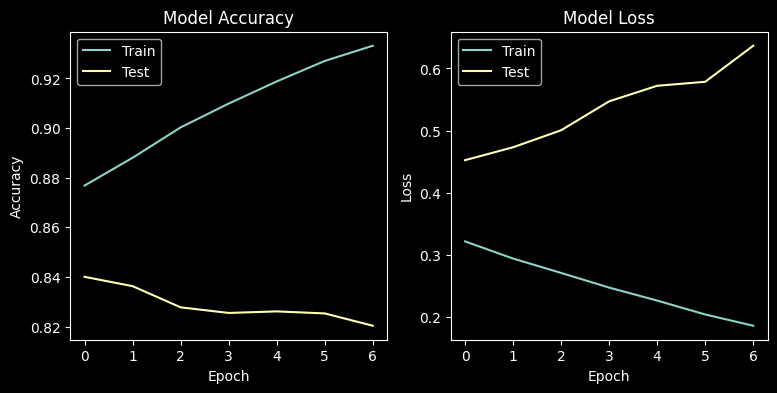

In [168]:
# training curve plotting
import matplotlib.pyplot as plt
def plot_training_history(history):
    plt.figure(figsize=(9, 4))
    plt.style.use('dark_background')

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    plt.show()
    
plot_training_history(model.history)

#### Work Notes - change in parameters vs Validation Accuracy:

[0.8590420484542847] - with 32 dense layer  + 0.2 split + 64 batch size

[0.7808787226676941] - without dense layer + 0.2 split + 64 batch size

[0.8557420372962952] - without dense layer + 128 batch size

[0.840750515460968] - without dense layer + 128 batch size + stop word, punctuation and digits removal

[0.831805646419525] - Dataset size increased + 128 dimensions + same above parameters

[0.8315544724464417] - 64 Dense Layer added

[0.836451530456543] - 128 LSTM units (earlier units = 64)

[0.832579970359802] - 64 LSTM units + 0.15 split

[0.8399673700332642] - 32 Dense layer + 0.2 split + 64 dimensions

Final - 32 Dense Layer + 128 batch Size + 0.2 split + stop word, punctuation and digits removal + 64 dimensions

[0.8399673700332642]